# Single Event with Complex Analysis

## Part One (Data Exploration)

#### Prerequisites
This notebook is designed to work with a Stroom server process running on `localhost`, into which data from `EventGen` application has been ingested and indexed in the manner described in `stroom-analytic-demo`.

You must set the environmental variable `STROOM_API_KEY` to the API token associated with a suitably privileged Stroom user account before starting the Jupyter notebook server process.

In [4]:
from pyspark.sql.types import *
from pyspark.sql.functions import from_json, col, coalesce, unix_timestamp,lit,to_timestamp,hour,date_format,date_trunc
from IPython.display import display
import time,os

#### Schema Discovery
It is necessary to specify the structure of the JSON data arriving on the topic.  This structure can be determined at runtime.

As the same format of data is also available via an indexed search using the `stroom-spark-datasource`, one way to determine the JSON schema is by interrogating the data held in the `Sample Index` Stroom index.

The specified pipeline is a Stroom Search Extraction Pipeline that uses the stroom:json XSLT function to create a JSON representation of the entire event.  This field is called "Json" by default but the name of the field that contains the JSON representation can (optionally) be changed with the parameter jsonField.

In this manner, all data is returned as a single JSON structure within the field **json**

In [5]:
spark = SparkSession \
    .builder \
    .appName("MyTestApp") \
    .getOrCreate()
schemaDf = spark.read.format('stroom.spark.datasource.StroomDataSource').load(
        token=os.environ['STROOM_API_KEY'],host='localhost',protocol='http',
        uri='api/stroom-index/v2',
        index='32dfd401-ee11-49b9-84c9-88c3d3f68dc2',pipeline='13143179-b494-4146-ac4b-9a6010cada89').\
        filter((col('idxEventTime') > '2019-10-01T00:00:00.000Z')
            & (col('idxEventTime') < '2019-12-01T00:00:00.000Z'))
json_schema = spark.read.json(schemaDf.rdd.map(lambda row: row.json)).schema

json_schema

StructType(List(StructField(EventDetail,StructType(List(StructField(Authenticate,StructType(List(StructField(Action,StringType,true),StructField(Outcome,StructType(List(StructField(Permitted,StringType,true),StructField(Reason,StringType,true),StructField(Success,StringType,true))),true),StructField(User,StructType(List(StructField(Id,StringType,true))),true))),true),StructField(Process,StructType(List(StructField(Action,StringType,true),StructField(Command,StringType,true),StructField(Type,StringType,true))),true),StructField(TypeId,StringType,true))),true),StructField(EventId,StringType,true),StructField(EventSource,StructType(List(StructField(Client,StructType(List(StructField(HostName,StringType,true))),true),StructField(Device,StructType(List(StructField(HostName,StringType,true))),true),StructField(Generator,StringType,true),StructField(System,StructType(List(StructField(Environment,StringType,true),StructField(Name,StringType,true))),true),StructField(User,StructType(List(Struct

## Data Visualisation
The shape of the data can be visualised

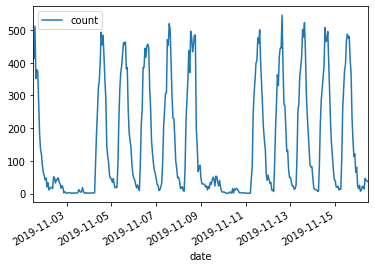

In [8]:
hoursDf = schemaDf.\
    withColumn('evt', from_json(col('json'), json_schema)).\
    withColumn ('timestamp', to_timestamp(col('evt.EventTime.TimeCreated')).cast("timestamp")).\
    withColumn ('user', col('evt.EventSource.User.Id')).\
    withColumn('operation', col('evt.EventDetail.TypeId')).\
    groupBy(date_trunc('hour',"timestamp").alias("date")).\
    count().sort(col('date'))
%matplotlib inline
hoursDf.toPandas().set_index('date').plot()

## Selecting the data for this analytic
We only need Authentication Failures - there is a highly visible spike in the data (due to simulated attack)

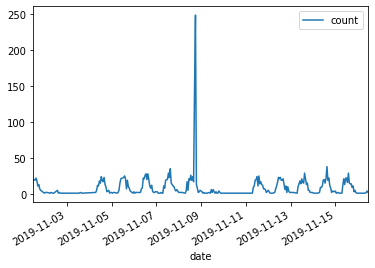

In [9]:
failuresDf = schemaDf.withColumn('evt', from_json(col('json'), json_schema)).\
    withColumn ('timestamp', to_timestamp(col('evt.EventTime.TimeCreated')).cast("timestamp")).\
    withColumn ('user', col('evt.EventSource.User.Id')).\
    withColumn('operation', col('evt.EventDetail.TypeId')).\
    where(col("operation") == "Authentication Failure")

failCounts = failuresDf.groupBy(col("operation"),date_trunc('hour',"timestamp").alias("date")).\
    count().sort(col('date'))

%matplotlib inline
failCounts.toPandas().set_index('date').plot()